In [11]:
import string
from copy import deepcopy
import pandas as pd
import numpy as np
from sklearn.decomposition import NMF
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import scipy
warnings.filterwarnings("ignore")

# Read normalized mean growth curve

In [2]:
df_mean_gc = pd.read_csv('../data/growth_curve_normalized/normalized_mean_growth_curve_PA_glycerol.csv', index_col=0)
df_mean_gc.index.name = 'Time'
df_mean_gc.head()

,F20590,F22031,F23197,F30658,F34365,F5677,F63912,F9670,H27930,H47921,...,T63266,W16407,W25637,W36662,W45909,W60856,W70332,W91453,X78812,X9820
Time,,,,,,,,,,,,,,,,,,,,,
0.0,0.003337,0.006417,0.003265,0.005668,0.005560,0.003057,0.006183,0.004500,0.004367,0.005983,...,0.001366,0.000287,0.001771,0.003265,0.000017,0.003639,0.000965,0.001764,0.002561,0.000554
0.1,0.003364,0.005618,0.003375,0.005207,0.007122,0.003108,0.005308,0.003876,0.003965,0.004442,...,0.001366,0.000287,0.001771,0.003373,0.000017,0.003704,0.000965,0.002041,0.003024,0.000554
0.2,0.003365,0.005404,0.003413,0.005176,0.007383,0.003115,0.005267,0.003800,0.003876,0.003810,...,0.001418,0.000392,0.001918,0.003433,0.000032,0.003795,0.000965,0.002554,0.003628,0.000554
0.3,0.003333,0.005443,0.003417,0.005634,0.006474,0.003074,0.006321,0.004326,0.003998,0.003619,...,0.001893,0.001340,0.003336,0.003460,0.000247,0.003924,0.000965,0.003489,0.004463,0.000554
0.4,0.003418,0.005420,0.003484,0.005554,0.006201,0.003155,0.006495,0.004710,0.004263,0.003769,...,0.001790,0.001355,0.003887,0.003503,0.000861,0.004042,0.001252,0.003603,0.004295,0.000931


# Read rhamnolipid production category

In [3]:
df_rhl = pd.read_excel('../data/rhamnolipids/rhamnMat.xlsx')
df_rhl.head()

,strain,rhamn3cats,rhamn2cats
0,F22031,2,1
1,F23197,2,1
2,F30658,1,1
3,F34365,2,1
4,F5677,0,0


In [4]:
df_rhl[df_rhl.strain=='W36662']

,strain,rhamn3cats,rhamn2cats
24,W36662,0,0


# Find shared strains between growth curve data and rhamnolipid production data

In [5]:
shared_strains = list(set(df_mean_gc.columns).intersection(set(df_rhl.strain)))
df_mean_gc = df_mean_gc[shared_strains]
df_rhl = df_rhl[df_rhl.strain.isin(shared_strains)]

# Plot all growth curves in a single graph

## plot individual curves

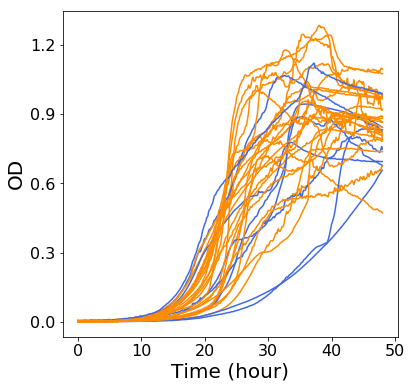

In [6]:
fig, ax = plt.subplots(1,1,figsize=(6,6))
for strain in df_mean_gc.columns:
    is_RL_producer = df_rhl.loc[df_rhl.strain==strain,'rhamn2cats'].values
    if is_RL_producer:
        plt.plot(df_mean_gc.index, df_mean_gc[strain], color='darkorange')
    else:
        plt.plot(df_mean_gc.index, df_mean_gc[strain], color='royalblue')
_ = plt.xlabel('Time (hour)',fontsize=20)
_ = plt.ylabel('OD',fontsize=20)
_ = plt.xticks([0,10,20,30,40,50], fontsize=16)
_ = plt.yticks([0,0.3,0.6,0.9,1.2], fontsize=16)
fig.savefig('growth_curves_grouped_by_rhamn2cat.svg', format='svg', dpi=1200)

## plot shades only

In [7]:
df_mean_gc_sns_format = df_mean_gc.stack().to_frame().reset_index()
df_mean_gc_sns_format.columns = ['time','strain','od']
df_mean_gc_sns_format = pd.merge(df_mean_gc_sns_format, df_rhl)
df_mean_gc_sns_format.head()

,time,strain,od,rhamn3cats,rhamn2cats
0,0.0,T52373,0.000253,2,1
1,0.1,T52373,0.000253,2,1
2,0.2,T52373,0.000342,2,1
3,0.3,T52373,0.001145,2,1
4,0.4,T52373,0.001252,2,1


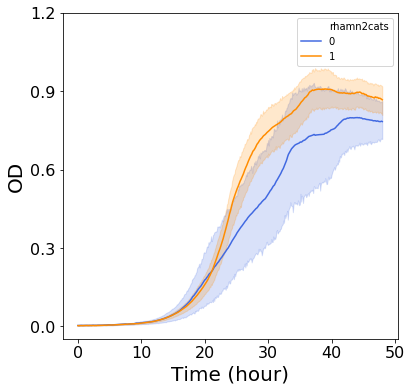

In [8]:
fig, ax = plt.subplots(1,1,figsize=(6,6))
sns.lineplot(x='time',y='od',hue='rhamn2cats',data=df_mean_gc_sns_format,ax=ax,palette={0:'royalblue',1:'darkorange'})
_ = plt.xlabel('Time (hour)',fontsize=20)
_ = plt.ylabel('OD',fontsize=20)
_ = plt.xticks([0,10,20,30,40,50], fontsize=16)
_ = plt.yticks([0,0.3,0.6,0.9,1.2], fontsize=16)

# Non-Negative Matrix Factorization

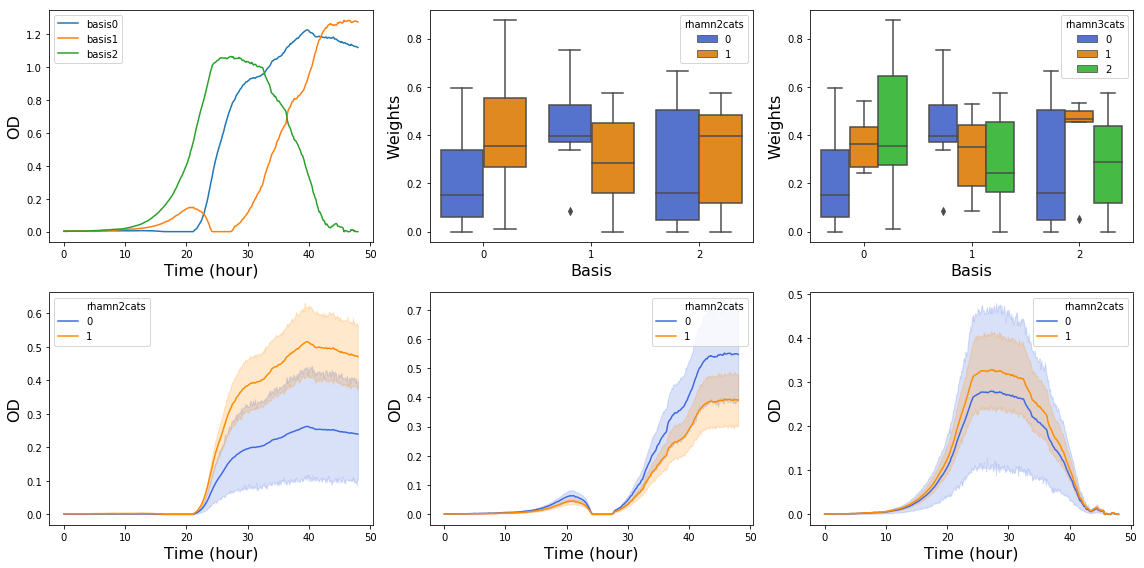

In [25]:
# perform non-negative matrix factorization
model = NMF(n_components=3, init='random', random_state=0, tol=1e-8)
W = model.fit_transform(df_mean_gc.values)
H = model.components_
    
# plot
fig, ax = plt.subplots(2,3,figsize=(16,8))
    
# plot basis function
for i in range(0,W.shape[1]):
    ax[0,0].plot(df_mean_gc.index, W[:,i], label='basis'+str(i))
ax[0,0].legend()
_ = ax[0,0].set_xlabel('Time (hour)',fontsize=16)
_ = ax[0,0].set_ylabel('OD',fontsize=16)
        
# plot weights
df_H = pd.DataFrame(H.transpose(), index=df_mean_gc.columns)
df_H = df_H.stack().to_frame().reset_index()
df_H.columns = ['strain','basis','weights']
    
res = []
for strain in df_H.strain:
    res.append(df_rhl.loc[df_rhl.strain==strain,['rhamn2cats','rhamn3cats']].values.tolist()[0])
df_res = pd.DataFrame(res, index=df_H.index)
df_res.columns = ['rhamn2cats','rhamn3cats']
df_H = pd.concat([df_H, df_res], axis=1)
    
sns.boxplot(x="basis", y="weights", hue="rhamn2cats", data=df_H, palette={0:'royalblue',1:'darkorange'}, ax=ax[0,1])
_ = ax[0,1].set_xlabel('Basis',fontsize=16)
_ = ax[0,1].set_ylabel('Weights',fontsize=16)
    
sns.boxplot(x="basis", y="weights", hue="rhamn3cats", data=df_H, palette={0:'royalblue',1:'darkorange',2:'limegreen'}, ax=ax[0,2])
_ = ax[0,2].set_xlabel('Basis',fontsize=16)
_ = ax[0,2].set_ylabel('Weights',fontsize=16)
    
# basis multiplied by weights
for basis in [0,1,2]:
    df_weighted_basis = pd.DataFrame(index=df_mean_gc.index, columns=df_mean_gc.columns)
    for index,strain in enumerate(df_weighted_basis.columns):
        df_weighted_basis[strain] = W[:,basis]*H[basis,index]
    df_weighted_basis_sns_format = df_weighted_basis.stack().to_frame().reset_index()
    df_weighted_basis_sns_format.columns = ['time','strain','od']
    df_weighted_basis_sns_format = pd.merge(df_weighted_basis_sns_format, df_rhl)
    
    sns.lineplot(x='time',y='od',hue='rhamn2cats',data=df_weighted_basis_sns_format,ax=ax[1,basis],palette={0:'royalblue',1:'darkorange'})
    _ = ax[1,basis].set_xlabel('Time (hour)',fontsize=16)
    _ = ax[1,basis].set_ylabel('OD',fontsize=16)
    
plt.tight_layout()
plt.show()

fig.savefig('nnmf.svg', format='svg', dpi=1200)

# test significance of weights difference between RL producer and non-producers

In [30]:
for i in [0,1,2]:
    df_H_basis_i = df_H[df_H.basis == i]
    RL_non_producing_group = df_H_basis_i.loc[df_H_basis_i.rhamn2cats==0,'weights']
    RL_producing_group = df_H_basis_i.loc[df_H_basis_i.rhamn2cats==1,'weights']
    _,pval = scipy.stats.ttest_ind(RL_non_producing_group, RL_producing_group, equal_var=False)
    print(pval)

0.032304593410916335
0.14110846594275714
0.666085833490168


# Using supervised learning to extract features

## extract growth curve features

In [45]:
%run auxiliary_function.py

df_growth_curve_feature = extract_growth_curve_features(
    file_od='../data/growth_curve_normalized/normalized_mean_growth_curve_PA_glycerol.csv',
    file_phase='../determine_growth_phases/PA_glycerol_growth_phase_start_time.csv',
    plot_dim=[5,7]
)

strain=F22031, phase=1, start_time=3.30, start_od=0.01, area=1.45, best_model=EXP (r2=1.00), growth_rate = [0.09, 0.02], specific_growth_rate = [0.25, 0.25]
strain=F22031, phase=2, start_time=20.60, start_od=0.35, area=11.99, best_model=EXP (r2=0.95), growth_rate = [0.07, 0.04], specific_growth_rate = [0.06, 0.06]
strain=F22031, phase=3, start_time=36.70, start_od=1.02, area=11.24, best_model=EXP (r2=0.99), growth_rate = [0.00, -0.00], specific_growth_rate = [0.00, -0.00]
strain=F23197, phase=1, start_time=12.80, start_od=0.01, area=2.44, best_model=EXP (r2=0.98), growth_rate = [0.09, 0.02], specific_growth_rate = [0.19, 0.19]
strain=F23197, phase=2, start_time=32.50, start_od=0.42, area=7.57, best_model=EXP (r2=0.98), growth_rate = [0.05, 0.04], specific_growth_rate = [0.06, 0.06]
strain=F23197, phase=3, start_time=43.60, start_od=0.89, area=3.76, best_model=EXP (r2=0.94), growth_rate = [0.02, -0.02], specific_growth_rate = [0.02, -0.02]
strain=F30658, phase=1, start_time=4.40, start_

In [46]:
df_growth_curve_feature = df_growth_curve_feature.fillna(0.0)
df_growth_curve_feature.head()

,strain,phase,start_time,end_time,delta_time,start_od,delta_od,area,best_model,r2,growth_rate_max,growth_rate_mean,specific_growth_rate_max,specific_growth_rate_mean
0,F22031,1,3.3,20.6,17.3,0.006426,0.341041,1.449650,EXP,0.996811,0.092024,0.021197,0.249327,0.249327
1,F22031,2,20.6,36.7,16.1,0.347467,0.669791,11.985124,EXP,0.945412,0.065825,0.042927,0.057574,0.057574
2,F22031,3,36.7,48.0,11.3,1.017258,-0.046485,11.244500,EXP,0.989257,0.003777,-0.004222,0.003710,-0.004248
3,F23197,1,12.8,32.5,19.7,0.008182,0.416802,2.441355,EXP,0.975862,0.091943,0.024289,0.188350,0.188350
4,F23197,2,32.5,43.6,11.1,0.424984,0.469181,7.573974,EXP,0.982909,0.053892,0.039710,0.058201,0.058201


In [53]:
df_growth_curve_feature.to_csv('tblgcfeatures.csv')

## run feature selection using random forest

In [13]:
df_classification = pd.read_csv('tblgcfeatures.csv', index_col=0)
df_classification.drop(['r2','end_time','best_model','growth_rate_max','growth_rate_mean'], axis=1)
df_classification.phase = df_classification.phase.astype(str)
df_classification = pd.pivot_table(df_classification, 
                         values=['start_time','delta_time','start_od','delta_od','area','specific_growth_rate_max','specific_growth_rate_mean'],
                         index=['strain'],
                         columns=['phase'],
                         aggfunc=np.mean
                        )
df_classification.columns = ['__'.join(x) for x in df_classification.columns.to_flat_index()]
df_classification = pd.merge(df_classification, df_rhl.set_index('strain',drop=True), left_on='strain', right_on='strain', how='left')
df_classification.drop(['rhamn3cats'], axis=1, inplace=True)
df_classification = df_classification[df_classification['rhamn2cats'].notnull()] # remove strains which do not have data for rhamnolipid production
df_classification['rhamn2cats'] = df_classification['rhamn2cats'].astype('category')

# # in case: remove rows and column whose values are all NaN
# df_classification = df_classification.dropna(axis=0,how='all')
# df_classification = df_classification.dropna(axis=1,how='all')

df_classification.head()

,area__1,area__2,area__3,delta_od__1,delta_od__2,delta_od__3,delta_time__1,delta_time__2,delta_time__3,specific_growth_rate_max__1,...,specific_growth_rate_mean__1,specific_growth_rate_mean__2,specific_growth_rate_mean__3,start_od__1,start_od__2,start_od__3,start_time__1,start_time__2,start_time__3,rhamn2cats
strain,,,,,,,,,,,,,,,,,,,,,
F22031,1.449650,11.985124,11.244500,0.341041,0.669791,-0.046485,17.3,16.1,11.3,0.249327,...,0.249327,0.057574,-0.004248,0.006426,0.347467,1.017258,3.3,20.6,36.7,1.0
F23197,2.441355,7.573974,3.763219,0.416802,0.469181,-0.100917,19.7,11.1,4.4,0.188350,...,0.188350,0.058201,-0.024434,0.008182,0.424984,0.894164,12.8,32.5,43.6,1.0
F30658,1.026965,4.154665,12.665739,0.382177,0.413794,-0.330257,17.8,6.2,19.6,0.523181,...,0.157303,0.109881,-0.027186,0.006743,0.388921,0.802715,4.4,22.2,28.4,1.0
F34365,1.510287,10.572320,10.553631,0.370286,0.571256,-0.059464,17.1,14.8,11.7,0.264798,...,0.233196,0.050129,-0.007589,0.008560,0.378846,0.950102,4.4,21.5,36.3,1.0
F5677,7.111104,0.065506,0.000000,0.641946,0.004151,0.000000,32.5,0.1,0.0,0.091215,...,0.091215,0.063366,0.005319,0.011036,0.652982,0.657133,15.4,47.9,48.0,0.0


In [15]:
X = df_classification.iloc[:,0:len(df_classification.columns)-1]
y = df_classification.iloc[:,-1]
model_rf = RandomForestClassifier(n_estimators=100000, n_jobs=-1, random_state=0)
model_rf.fit(X,y)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100000,
                       n_jobs=-1, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

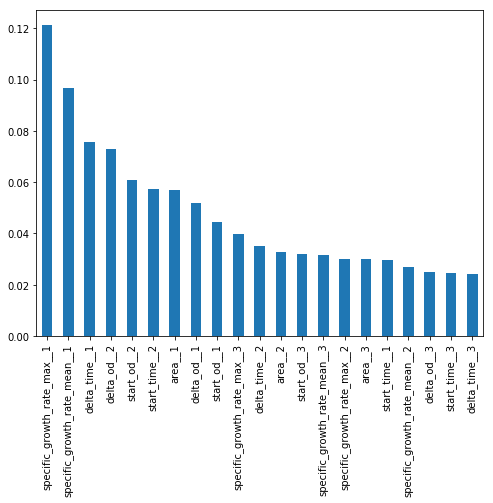

In [16]:
fig, ax = plt.subplots(1,1,figsize=(8,6))
feat_importances = pd.Series(model_rf.feature_importances_, index=X.columns)
feat_importances.nlargest(1000).plot(kind='bar')
plt.show()
fig.savefig('feature_importance_RF.svg', format='svg', dpi=1200)

## Test significance of features

In [28]:
pvallist = []
featurelist = []
for feature in df_classification.columns:
    if feature != 'rhamn2cats':
        RL_non_producing_group = list(df_classification.loc[df_classification.rhamn2cats==0, feature].values)
        RL_producing_group = list(df_classification.loc[df_classification.rhamn2cats==1, feature].values)
        _,pval = scipy.stats.ttest_ind(RL_non_producing_group, RL_producing_group, equal_var=False)
        pvallist.append(pval)
        featurelist.append(feature)
        
order = np.argsort(pvallist)
pvallist = [pvallist[x] for x in order]
featurelist = [featurelist[x] for x in order]

for feature,pval in zip(featurelist, pvallist):
    if (pval <= 0.05):
        print("SIGNIFICANT, %s, p-value = %2.2e"%(feature, pval))
    else:
        print("NOT SIGNIFICANT, %s, p-value = %2.2e"%(feature, pval))

SIGNIFICANT, specific_growth_rate_max__1, p-value = 9.17e-05
SIGNIFICANT, specific_growth_rate_mean__1, p-value = 2.52e-02
SIGNIFICANT, area__1, p-value = 2.74e-02
SIGNIFICANT, delta_time__1, p-value = 3.24e-02
SIGNIFICANT, delta_od__2, p-value = 4.18e-02
NOT SIGNIFICANT, area__2, p-value = 5.53e-02
NOT SIGNIFICANT, start_time__2, p-value = 5.97e-02
NOT SIGNIFICANT, delta_time__2, p-value = 7.21e-02
NOT SIGNIFICANT, start_od__1, p-value = 7.79e-02
NOT SIGNIFICANT, start_od__2, p-value = 9.17e-02
NOT SIGNIFICANT, delta_od__1, p-value = 9.55e-02
NOT SIGNIFICANT, specific_growth_rate_max__3, p-value = 1.98e-01
NOT SIGNIFICANT, start_od__3, p-value = 2.25e-01
NOT SIGNIFICANT, start_time__1, p-value = 2.66e-01
NOT SIGNIFICANT, area__3, p-value = 3.87e-01
NOT SIGNIFICANT, start_time__3, p-value = 4.71e-01
NOT SIGNIFICANT, delta_time__3, p-value = 4.71e-01
NOT SIGNIFICANT, specific_growth_rate_mean__2, p-value = 5.00e-01
NOT SIGNIFICANT, specific_growth_rate_mean__3, p-value = 8.19e-01
NOT SI

## Plot comparison of features between producing and non-producing strains

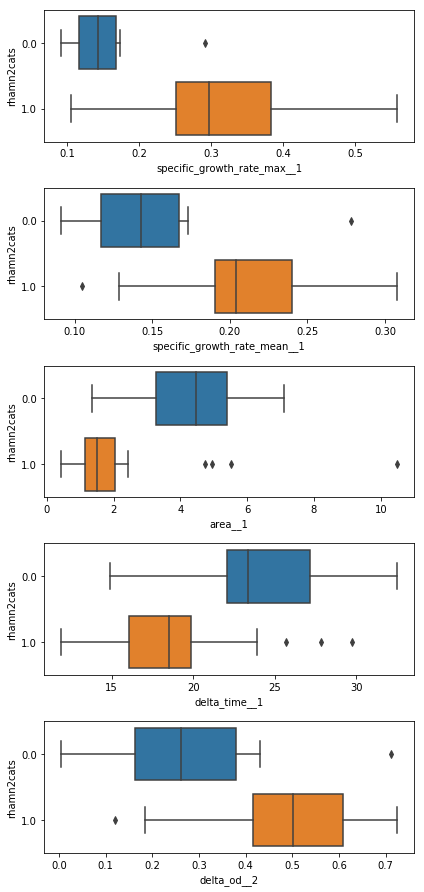

In [29]:
features_to_compare = ['specific_growth_rate_max__1',
                       'specific_growth_rate_mean__1',
                       'area__1',
                       'delta_time__1',
                       'delta_od__2']

fig, ax = plt.subplots(len(features_to_compare),1,figsize=(6, 2.5*len(features_to_compare)))
for index, feature in enumerate(features_to_compare):
    g = sns.boxplot(y='rhamn2cats', x=feature, data=df_classification, ax=ax[index], orient='h')
    #g.set_xticklabels(g.get_xticklabels(), rotation=90)
    
plt.tight_layout()
plt.show()
fig.savefig('boxplot_growth_curve_features.svg', format='svg', dpi=1200)